In [51]:
#Basic Libraries
import pandas as pd
import numpy as np
import datetime as dt


#Visualizations
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


# ML Matrix + Performance params
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix

#Fixing Balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from collections import Counter
from imblearn.pipeline import Pipeline


#Load the ML Algos
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.cluster import DBSCAN
#For Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Geospatial
import contextily as cx
from shapely.geometry import Point, Polygon
import xarray as xr
import rasterio.features
import rasterio as rio
import fsspec

# API
import requests
import json

# Import Planetary Computer
# import stackstac
import pystac
import pystac_client
import planetary_computer

# Other
import os
from itertools import cycle

In [7]:
bbox_coordinates =  {'0' : (144.8,-38.5,145.8,-37.5),
                     '1' : (150.7,-33.5,151.7,-32.5),
                     '2' : (152.6,-29.0,153.6,-28.0),
                     '3' : (145.0,-17.7,146.0,-16.7),
                     '4' : (115.7,-32.5,116.7,-31.5)}

In [8]:
#final_frog_data.to_csv('final_cluster_frog.csv')
final_data = pd.read_csv('final_cluster_frog.csv').drop('Unnamed: 0', axis=1)
final_data

,decimalLatitude,decimalLongitude,cluster,occurrenceStatus
0,-38.369245,144.979495,0,0
1,-38.322200,145.190000,0,0
2,-37.718300,145.053000,0,0
3,-37.733000,144.973000,0,0
4,-37.796300,145.112000,0,0
...,...,...,...,...
19770,-31.947500,115.891000,4,0
19771,-31.879395,116.194904,4,0
19772,-32.119700,116.102869,4,0
19773,-31.771600,115.988000,4,0


In [9]:


# X_balance = final_data[[ 'decimalLatitude', 'decimalLongitude','cluster']]
# y_balance = final_data['occurrenceStatus']

# # summarize class distribution
# print(Counter(y_balance))

# #define pipeline
# smt = SMOTETomek(sampling_strategy = 'auto')
# X_res, y_res = smt.fit_resample(X_balance, y_balance)



# # # define undersample strategy
# # undersample = RandomUnderSampler(sampling_strategy=1)
# # X_res, y_res = undersample.fit_resample(X_balance, y_balance)


# all_frog_data = pd.concat([X_res, y_res], axis=1)
# # summarize class distribution
# print(Counter(y_res))
all_frog_data = final_data.copy()


In [10]:
len(all_frog_data)

19775

In [11]:
all_frog_data = (
    all_frog_data.reset_index(drop=True).assign(key= lambda x: x.index))
all_frog_data.cluster = all_frog_data.cluster.astype(int)
all_frog_data

,decimalLatitude,decimalLongitude,cluster,occurrenceStatus,key
0,-38.369245,144.979495,0,0,0
1,-38.322200,145.190000,0,0,1
2,-37.718300,145.053000,0,0,2
3,-37.733000,144.973000,0,0,3
4,-37.796300,145.112000,0,0,4
...,...,...,...,...,...
19770,-31.947500,115.891000,4,0,19770
19771,-31.879395,116.194904,4,0,19771
19772,-32.119700,116.102869,4,0,19772
19773,-31.771600,115.988000,4,0,19773


In [12]:
all_frog_data.groupby(['cluster','occurrenceStatus']).count()['key']

cluster  occurrenceStatus
0        0                    445
         1                    156
1        0                   7899
         1                   7701
2        0                    784
         1                   1120
3        0                    206
         1                    457
4        0                   1007
Name: key, dtype: int64

In [13]:
for bbox_num in range(len(bbox_coordinates)):
    print(list(bbox_coordinates.values())[bbox_num])

(144.8, -38.5, 145.8, -37.5)
(150.7, -33.5, 151.7, -32.5)
(152.6, -29.0, 153.6, -28.0)
(145.0, -17.7, 146.0, -16.7)
(115.7, -32.5, 116.7, -31.5)


In [15]:
def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
        
    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return combined_data

In [16]:
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(frogs.decimalLongitude, dims="key", coords={"key": frogs.key}), 
                y=xr.DataArray(frogs.decimalLatitude, dims="key", coords={"key": frogs.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot_table(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )

In [37]:
# Metrics to measure over time dimension
tc_metrics = {
    'mean':{
        'fn':np.nanmean,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    }
}

# Date range to take
time_slice = ('2000-01-01','2021-12-31')

# Measurements to take
assets=['tmax', 'tmin', 'ppt', 'soil',
       'aet', 
        'def', 
        'pet', 
        'vap', 
        'vpd', 
        'pdsi', 
        'srad']

# Features to take, in form '<asset>_<metric>'
features=['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean', 
          'aet_mean', 
          'def_mean', 
          'pet_mean',
          'vap_mean', 
          'vpd_mean', 
          'pdsi_mean', 
          'srad_mean']

# Interpolate values to a 512x512 image
interp_dims = (512, 512)


model_data = pd.DataFrame()

for bbox_num in range(len(bbox_coordinates)):
    
    bbox = list(bbox_coordinates.values())[bbox_num]
    
    frog_data_temp = all_frog_data.loc[all_frog_data.cluster == bbox_num]
    
    weather_data = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
    display(weather_data.band.values)
    
    model_temp = join_frogs(frog_data_temp, weather_data)
    
    model_data = pd.concat([model_data,model_temp])

Loading data
Calculating mean


C:\Users\LR996GB\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: Mean of empty slice
  results = func(*(arg[index] for arg in args))


Calculating min
Calculating max
Interpolating image


C:\Users\LR996GB\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: All-NaN slice encountered
  results = func(*(arg[index] for arg in args))


array(['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean', 'aet_mean',
       'def_mean', 'pet_mean', 'vap_mean', 'vpd_mean', 'pdsi_mean',
       'srad_mean'], dtype='<U9')

Loading data
Calculating mean


C:\Users\LR996GB\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: Mean of empty slice
  results = func(*(arg[index] for arg in args))


Calculating min
Calculating max
Interpolating image


C:\Users\LR996GB\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: All-NaN slice encountered
  results = func(*(arg[index] for arg in args))


array(['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean', 'aet_mean',
       'def_mean', 'pet_mean', 'vap_mean', 'vpd_mean', 'pdsi_mean',
       'srad_mean'], dtype='<U9')

Loading data
Calculating mean


C:\Users\LR996GB\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: Mean of empty slice
  results = func(*(arg[index] for arg in args))
C:\Users\LR996GB\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: All-NaN slice encountered
  results = func(*(arg[index] for arg in args))


Calculating min
Calculating max
Interpolating image


array(['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean', 'aet_mean',
       'def_mean', 'pet_mean', 'vap_mean', 'vpd_mean', 'pdsi_mean',
       'srad_mean'], dtype='<U9')

Loading data
Calculating mean


C:\Users\LR996GB\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: Mean of empty slice
  results = func(*(arg[index] for arg in args))


Calculating min


C:\Users\LR996GB\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: All-NaN slice encountered
  results = func(*(arg[index] for arg in args))


Calculating max
Interpolating image


array(['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean', 'aet_mean',
       'def_mean', 'pet_mean', 'vap_mean', 'vpd_mean', 'pdsi_mean',
       'srad_mean'], dtype='<U9')

Loading data
Calculating mean


C:\Users\LR996GB\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: Mean of empty slice
  results = func(*(arg[index] for arg in args))


Calculating min


C:\Users\LR996GB\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: All-NaN slice encountered
  results = func(*(arg[index] for arg in args))


Calculating max
Interpolating image


array(['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean', 'aet_mean',
       'def_mean', 'pet_mean', 'vap_mean', 'vpd_mean', 'pdsi_mean',
       'srad_mean'], dtype='<U9')

In [38]:
model_data.tail()

,decimalLatitude,decimalLongitude,cluster,occurrenceStatus,key,aet_mean,def_mean,pdsi_mean,pet_mean,ppt_mean,soil_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean
1002,-31.947500,115.891000,4,0,19770,49.916668,92.229164,-2.093750,142.108337,54.462502,58.495834,232.899994,24.615835,13.185419,1.324500,1.062833
1003,-31.879395,116.194904,4,0,19771,49.000000,81.824997,-1.217500,130.824997,67.033333,53.987499,231.512497,23.118753,10.332501,1.135708,1.000167
1004,-32.119700,116.102869,4,0,19772,53.062500,76.050003,-1.493750,129.120834,77.266670,66.079170,231.070831,22.762918,10.581252,1.161458,0.952500
1005,-31.771600,115.988000,4,0,19773,47.091667,93.679169,-1.676666,140.766663,53.795834,49.404167,233.633331,24.751253,12.317919,1.283958,1.088125
1006,-31.770800,115.988000,4,0,19774,47.091667,93.679169,-1.676666,140.766663,53.795834,49.404167,233.633331,24.751253,12.317919,1.283958,1.088125


In [39]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19735 entries, 0 to 1006
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   decimalLatitude   19735 non-null  float64
 1   decimalLongitude  19735 non-null  float64
 2   cluster           19735 non-null  int32  
 3   occurrenceStatus  19735 non-null  int64  
 4   key               19735 non-null  int64  
 5   aet_mean          19735 non-null  float32
 6   def_mean          19735 non-null  float32
 7   pdsi_mean         19735 non-null  float32
 8   pet_mean          19735 non-null  float32
 9   ppt_mean          19735 non-null  float32
 10  soil_mean         19735 non-null  float32
 11  srad_mean         19735 non-null  float32
 12  tmax_mean         19735 non-null  float32
 13  tmin_mean         19735 non-null  float32
 14  vap_mean          19735 non-null  float32
 15  vpd_mean          19735 non-null  float32
dtypes: float32(11), float64(2), int32(1), int

In [41]:
model_data.to_csv('terraclimate2000_2021_10_features2000_2021.csv')

In [20]:
#model_data = pd.read_csv('terraclimate2000_2021_10_features.csv').drop('Unnamed: 0',axis=1)

In [42]:
model_data.describe()

,decimalLatitude,decimalLongitude,cluster,occurrenceStatus,key,aet_mean,def_mean,pdsi_mean,pet_mean,ppt_mean,soil_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,-32.268299,149.386061,1.286243,0.477578,9894.313707,76.634140,35.687546,-1.813909,112.289444,90.551682,83.774002,199.328995,23.545721,12.801207,1.465370,0.768800
std,3.307221,7.928176,0.799121,0.499510,5709.570984,11.791684,15.690877,0.323310,8.689060,22.193590,45.556618,10.593624,1.273565,1.508682,0.174254,0.089478
min,-38.498100,115.707234,0.000000,0.000000,0.000000,38.508335,12.725000,-3.705416,90.387497,40.537498,5.400000,176.120834,17.325003,6.448751,0.980958,0.518375
25%,-33.324900,151.351598,1.000000,0.000000,4950.500000,73.695831,28.145834,-1.867916,107.566666,80.941666,71.479164,194.629166,22.940002,12.382502,1.426958,0.721292
50%,-33.277588,151.365000,1.000000,0.000000,9904.000000,79.441666,28.758333,-1.865000,110.045830,93.687500,77.537498,195.812500,23.179167,12.382502,1.426958,0.734250
75%,-32.798841,151.481000,1.000000,1.000000,14838.500000,80.587502,37.462502,-1.717500,113.400002,94.654167,82.837502,197.962494,23.910835,13.185419,1.475667,0.768958
max,-16.739402,153.599672,4.000000,1.000000,19774.000000,116.820831,95.958336,0.195417,144.250000,297.283325,403.029175,235.012497,29.426668,20.836670,2.424583,1.129917


In [43]:
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['decimalLatitude', 'decimalLongitude', 'occurrenceStatus', 'key','cluster'], 1).reset_index(drop=True)
)
y = model_data.occurrenceStatus.astype(int)

C:\Users\LR996GB\Anaconda3\envs\frogs\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [61]:
#PREDICTOR VARIABLES
X

,aet_mean,def_mean,pdsi_mean,pet_mean,ppt_mean,soil_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean
0,57.349998,37.020832,-2.745000,94.287498,63.779167,55.966667,176.204163,18.239588,10.112501,1.173500,0.518375
1,55.075001,44.933334,-3.302917,99.974998,58.470833,53.091667,177.887497,19.442921,10.526251,1.211417,0.586833
2,51.862499,57.745834,-2.907916,109.558334,54.608334,24.887501,179.033340,20.685835,10.147502,1.149333,0.738208
3,46.799999,62.987499,-2.806249,109.704170,49.241665,15.220834,178.625000,20.606668,10.179585,1.158167,0.720208
4,55.424999,54.179165,-3.036666,109.562500,58.387501,32.445835,178.795837,20.659586,10.347918,1.153167,0.737917
...,...,...,...,...,...,...,...,...,...,...,...
19730,49.916668,92.229164,-2.093750,142.108337,54.462502,58.495834,232.899994,24.615835,13.185419,1.324500,1.062833
19731,49.000000,81.824997,-1.217500,130.824997,67.033333,53.987499,231.512497,23.118753,10.332501,1.135708,1.000167
19732,53.062500,76.050003,-1.493750,129.120834,77.266670,66.079170,231.070831,22.762918,10.581252,1.161458,0.952500
19733,47.091667,93.679169,-1.676666,140.766663,53.795834,49.404167,233.633331,24.751253,12.317919,1.283958,1.088125


In [62]:
#TARGET VARIABLES
y

0       0
1       0
2       0
3       0
4       0
       ..
1002    0
1003    0
1004    0
1005    0
1006    0
Name: occurrenceStatus, Length: 19735, dtype: int32

In [46]:
y.value_counts()

0    10310
1     9425
Name: occurrenceStatus, dtype: int64

# example of a standardization
from sklearn.preprocessing import StandardScaler
# define data
data = X
# define standard scaler
scaler = StandardScaler()
# transform data
X_scaled = scaler.fit_transform(data)

In [64]:
# example of a normalization
from sklearn.preprocessing import MinMaxScaler
# define data
data = X
# define min max scaler
scaler = MinMaxScaler()
# transform data
X_scaled = scaler.fit_transform(data)
print(X_scaled)

[[0.24059585 0.29190028 0.24620807 ... 0.2546407  0.13337368 0.        ]
 [0.21154562 0.38696432 0.10318303 ... 0.28339744 0.15963858 0.11194378]
 [0.17052403 0.54089904 0.20444351 ... 0.25707334 0.11663347 0.35947388]
 ...
 [0.18584725 0.760813   0.56697285 ... 0.28722018 0.12503248 0.70988625]
 [0.10960361 0.9726171  0.52008116 ... 0.40792328 0.20988828 0.9316618 ]
 [0.10960361 0.9726171  0.52008116 ... 0.40792328 0.20988828 0.9316618 ]]


X_scaled = X


from imblearn.combine import SMOTETomek
from collections import Counter



X_balance = X
y_balance = y

# summarize class distribution
print(Counter(y_balance))

smt = SMOTETomek(sampling_strategy = 'all')
X_res, y_res = smt.fit_resample(X_balance, y_balance)

# all_frog_data = pd.concat([X_res, y_res], axis=1)
# summarize class distribution
print(Counter(y_res))

pairplot_data = pd.concat([X_res,y_res], axis=1)

sns.pairplot(pairplot_data)

In [78]:
y = y.astype('category')

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.10, random_state=1)

In [80]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=5) 

In [81]:
def report(model):
    preds = model.predict(X_test)
    print(classification_report(y_test,preds))
    plot_confusion_matrix(model,X_test,y_test)
    print(f"F1 Score: {np.mean(f1_score(y_test, preds)).round(2)}")
    print(f"Accuracy: {np.mean(accuracy_score(y_test, preds)).round(2)}")

### Logisitic Regression

LR = LogisticRegression()

#Parameters
solvers = ['newton-cg', 'lbfgs']
penalty = ['l2']
c_values = [300, 250,200,100]

#ParametersGrid
lr_param_grid = dict(solver=solvers,penalty=penalty,C=c_values)

#GridSearchCV
gsLR = GridSearchCV(LR,param_grid = lr_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsLR.fit(X_train,y_train)

# Summarize the results
LR_best = gsLR.best_estimator_
print('Best : {}, using {}'.format(gsLR.best_score_,gsLR.best_params_))
report(gsLR)

# Train the model
LSVC = LinearSVC()

#Parameters
class_weight=[None]
dual=[True]
tol=[1e-3,1e-2]
max_iter=[1e5]

#ParametersGrid
lsvc_param_grid = dict(class_weight=class_weight,dual=dual,tol=tol,max_iter=max_iter)

#GridSearchCV
gsLSVC = GridSearchCV(LSVC,param_grid = lsvc_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsLSVC.fit(X_train,y_train)

#Summarize the results
LSVC_best = gsLSVC.best_estimator_
print('Best : {}, using {}'.format(gsLSVC.best_score_,gsLSVC.best_params_))
report(gsLSVC)

RFC = RandomForestClassifier()
RFC.get_params().keys()

##### Train the model
RFC = RandomForestClassifier()


#Parameters
rf_param_grid = {"max_depth": [20,40,55],
              "bootstrap": [True],
              "n_estimators" :[10,15,20,100],
              "criterion": ["gini","entropy"],
                 "class_weight" : ["balanced"],            
                "max_leaf_nodes":[None, 5, 10, 20,100]}

# n_estimators=1000,criterion='conf',conf=[0.95,0.95]

#GridSearchCV
gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 2)
gsRFC.fit(X_train,y_train)

# Summarize the results
RFC_best = gsRFC.best_estimator_
print('Best : {}, using {}'.format(gsRFC.best_score_,gsRFC.best_params_))
report(gsRFC)

#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None, 10, 20, 50],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False,True],
              "n_estimators" :[200,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsExtC.fit(X_train,y_train)

# Summarize the results
ExtC_best = gsExtC.best_estimator_
print('Best : {}, using {}'.format(gsExtC.best_score_,gsExtC.best_params_))
report(gsExtC)

### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf','linear','poly','sigmoid'], 
                  'gamma': ['scale','auto'],
                  'C': [1,100,300,500]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 2)

gsSVMC.fit(X_train,y_train)

# Summarize the results
SVMC_best = gsSVMC.best_estimator_
print('Best : {}, using {}'.format(gsSVMC.best_score_,gsSVMC.best_params_))
report(gsSVMC)

In [93]:
#MLP

MLP = MLPClassifier(max_iter=500)

# mlp_param_grid = {
#     'hidden_layer_sizes': [(50,50),(100)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive']}

mlp_param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001,0.001, 0.05],
    'learning_rate': ['constant','adaptive']}

gsMLP = GridSearchCV(MLP,param_grid = mlp_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = True)
gsMLP.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 36.6min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 51.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=MLPClassifier(max_iter=500), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             scoring='accuracy', verbose=True)

Best : 0.6341423343551826, using {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
              precision    recall  f1-score   support

           0       0.72      0.50      0.59      1052
           1       0.58      0.78      0.66       922

    accuracy                           0.63      1974
   macro avg       0.65      0.64      0.63      1974
weighted avg       0.66      0.63      0.63      1974

F1 Score: 0.66
Accuracy: 0.63


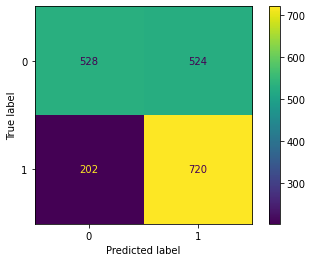

In [94]:
# Summarize the results
MLP_best = gsMLP.best_estimator_
print('Best : {}, using {}'.format(gsMLP.best_score_,gsMLP.best_params_))
report(gsMLP)

In [73]:
#XGBooster

XGB = XGBClassifier()

xgb_param_grid = {
                    "learning_rate"    : [0.01] ,
                  "min_child_weight" : [4,5,6],
                  "max_depth"        : [4,5,6]
#                   "gamma"            : [ 0.0, 0.1, 0.2],
#                   "colsample_bytree" : [ 0.5,0.6 ]
}

gsXGB = GridSearchCV(XGB,param_grid = xgb_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsXGB.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 16.8min finished
C:\Users\LR996GB\Anaconda3\envs\frogs\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, mi...e,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                         

Best : 0.6583527148736127, using {'max_depth': 4, 'min_child_weight': 4}
              precision    recall  f1-score   support

           0       0.73      0.56      0.63      1052
           1       0.60      0.77      0.68       922

    accuracy                           0.66      1974
   macro avg       0.67      0.66      0.65      1974
weighted avg       0.67      0.66      0.65      1974

F1 Score: 0.68
Accuracy: 0.66


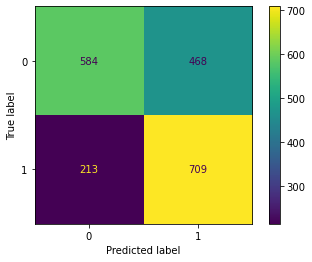

In [74]:
# Summarize the results
XGB_Best = gsXGB.best_estimator_
print('Best : {}, using {}'.format(gsXGB.best_score_,gsXGB.best_params_))
report(gsXGB)

In [54]:
df1 = pd.read_csv('Level_1_challenge_1_submission_template.csv')

In [55]:
def join_frogs_sub(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(df1.decimalLongitude, dims="id", coords={"id": df1.id}), 
                y=xr.DataArray(df1.decimalLatitude, dims="id", coords={"id": df1.id}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="id", columns="band", values="val")
            .reset_index()
        ),
        on = ['id'],
        how = 'inner'
    )
    
test_data = join_frogs_sub(df1, weather_data)
test_data.head()

,id,decimalLatitude,decimalLongitude,occurrenceStatus,aet_mean,def_mean,pdsi_mean,pet_mean,ppt_mean,soil_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean
0,0,-37.917146,145.207706,NaN,34.262501,94.183334,-1.266666,128.458328,40.008335,19.329166,227.787506,23.28417,9.011668,1.065542,1.043167
1,1,-37.750974,144.981501,NaN,34.262501,94.183334,-1.266666,128.458328,40.008335,19.329166,227.787506,23.28417,9.011668,1.065542,1.043167
2,2,-37.961600,145.348000,NaN,34.262501,94.183334,-1.266666,128.458328,40.008335,19.329166,227.787506,23.28417,9.011668,1.065542,1.043167
3,3,-37.621300,145.003000,NaN,34.262501,94.183334,-1.266666,128.458328,40.008335,19.329166,227.787506,23.28417,9.011668,1.065542,1.043167
4,4,-38.498100,145.647000,NaN,34.262501,94.183334,-1.266666,128.458328,40.008335,19.329166,227.787506,23.28417,9.011668,1.065542,1.043167


In [69]:
data = test_data.iloc[:,4:]

# define min max scaler
scaler = MinMaxScaler()

# transform data
test_Scaled = scaler.fit_transform(data)

In [70]:
test_Scaled

array([[0.21700251, 0.45815337, 0.84201777, ..., 0.        , 0.        ,
        0.24422169],
       [0.21700251, 0.45815337, 0.84201777, ..., 0.        , 0.        ,
        0.24422169],
       [0.21700251, 0.45815337, 0.84201777, ..., 0.        , 0.        ,
        0.24422169],
       ...,
       [0.825428  , 0.34150946, 0.15687358, ..., 0.88615537, 0.8842983 ,
        0.12742901],
       [0.6531292 , 0.27160752, 0.96202886, ..., 0.33507943, 0.24279404,
        0.2710166 ],
       [0.63085306, 0.46036422, 0.9079823 , ..., 0.5964453 , 0.42025805,
        0.48936367]], dtype=float32)

In [59]:
def get_result(model,test_Scaled):
    test_result = model.predict(test_Scaled)
    df1.occurrenceStatus = test_result
    print(df1.occurrenceStatus.value_counts())
    

In [ ]:
get_result(gsLR, test_Scaled)

In [ ]:
get_result(gsRFC, test_Scaled)

get_result(gsExtC, test_Scaled)

In [ ]:
get_result(gsSVMC, test_Scaled)

In [95]:
get_result(gsMLP, test_Scaled)

0    2985
1    1066
Name: occurrenceStatus, dtype: int64


In [88]:
get_result(gsXGB, test_Scaled)

0    3625
1     426
Name: occurrenceStatus, dtype: int64


In [96]:
df1.to_csv('fine_tunedMLP.csv')
